# Compute Benchmark Metrics for IS Methods 

In [1]:
# !pip install tqdm numpy matplotlib pandas seaborn
import os
import tqdm
import copy
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
warnings.simplefilter(action='ignore')

In [2]:
results_path = './evaluation_results'
exps_paths = {
  'Base', 'User', 'SamplingUsersCount', 
  'Trajectory_BOUNDS_0.000_0.100', 'Trajectory_BOUNDS_0.100_0.200', 
  'Trajectory_BOUNDS_0.200_0.300', 'Trajectory_BOUNDS_0.300_0.400',
  'Trajectory_BOUNDS_0.400_0.500', 'Trajectory_BOUNDS_0.500_0.600',
  'Trajectory_BOUNDS_0.600_0.700', 'Trajectory_BOUNDS_0.700_0.800',
  'Trajectory_BOUNDS_0.800_0.900', 'Trajectory_BOUNDS_0.900_1.000'
}
exps_paths = {x: results_path for x in exps_paths}

In [3]:
map_names_to_print = {

'GPCIS_Resnet50' : ["GPCIS", "RN50", "C+L"],
'cclvs_last_checkpoint' : ["CDNet", "RN34", "C+L"],
'sbd_last_checkpoint' : ["CDNet", "RN34", "SBD"],
'coco_lvis_h18_baseline' : ["RITM", "HR18", "C+L"],
'coco_lvis_h18s_itermask' : ["RITM", "HR18s-IT", "C+L"],
'coco_lvis_h18_itermask' : ["RITM", "HR18-IT", "C+L"],
'coco_lvis_h32_itermask' : ["RITM", "HR32-IT", "C+L"],
'sbd_h18_itermask' : ["RITM", "HR18-IT", "SBD"],
'adaptiveclick_base448_cocolvis' : ["AdaptClick", "ViT-B", "C+L"],
'adaptiveclick_base448_sbd' : ["AdaptClick", "ViT-B", "SBD"],
'cocolvis_vit_base' : ["SimpleClick", "ViT-B", "C+L"],
'cocolvis_vit_large' : ["SimpleClick", "ViT-L", "C+L"],
'cocolvis_vit_huge' : ["SimpleClick", "ViT-H", "C+L"],
'sbd_vit_xtiny' : ["SimpleClick", "ViT-XT", "SBD"],
'sbd_vit_base' : ["SimpleClick", "ViT-B", "SBD"],
'sbd_vit_large' : ["SimpleClick", "ViT-L", "SBD"],
'sbd_vit_huge' : ["SimpleClick", "ViT-H", "SBD"],
'cocolvis_icl_vit_huge' : ["CFR-ICL", "ViT-H", "C+L"],
'mobile_sam' : ["MobileSAM", "ViT-Tiny", "SA-1B"],
'sam_vit_b_01ec64' : ["SAM", "ViT-B", "SA-1B"],
'sam_vit_l_0b3195' : ["SAM", "ViT-L", "SA-1B"],
'sam_vit_h_4b8939' : ["SAM", "ViT-H", "SA-1B"],
'sam_hq_vit_b' : ["SAM-HQ", "ViT-B", "SA-1B"],
'sam_hq_vit_l' : ["SAM-HQ", "ViT-L", "SA-1B"],
'sam_hq_vit_h' : ["SAM-HQ", "ViT-H", "SA-1B"],
'sam2_hiera_tiny' : ["SAM2", "Hiera-T", "SA-V"],
'sam2_hiera_small' : ["SAM2", "Hiera-S", "SA-V"],
'sam2_hiera_base_plus' : ["SAM2", "Hiera-B+", "SA-V"],
'sam2_hiera_large' : ["SAM2", "Hiera-L", "SA-V"],
'sam2.1_hiera_tiny' : ["SAM2.1", "Hiera-T", "SA-V"],
'sam2.1_hiera_small' : ["SAM2.1", "Hiera-S", "SA-V"],
'sam2.1_hiera_base_plus' : ["SAM2.1", "Hiera-B+", "SA-V"],
'sam2.1_hiera_large' : ["SAM2.1", "Hiera-L", "SA-V"]
}

In [4]:
data_dict = {}
for model_name in tqdm.tqdm(map_names_to_print.keys()):
    data_dict[model_name] = {}
    for suffix in exps_paths.keys():
        model = model_name + '_' + suffix
        model_path = os.path.join(exps_paths[suffix], model, 'plots')
        if not os.path.exists(model_path):
            print("Missed:", model_path)
            continue
        for dataset_name in os.listdir(model_path):
            
            if dataset_name.split('_')[0] not in data_dict[model_name]:
                data_dict[model_name][dataset_name.split('_')[0]] = {}
            list_per_click = []
            list_per_click_biou = []
            data = pickle.load(open(os.path.join(model_path, dataset_name), "rb"))

            for per_image_metrics in data['all_ious']:                    
                list_per_click.append(per_image_metrics[1][:, 0])
                list_per_click_biou.append(per_image_metrics[1][:, 1])
            data_dict[model_name][dataset_name.split('_')[0]][suffix + '_IOU'] = np.array(list_per_click)
            data_dict[model_name][dataset_name.split('_')[0]][suffix + '_BIOU'] = np.array(list_per_click_biou)

100%|██████████| 33/33 [03:34<00:00,  6.49s/it]


In [5]:
inverse_index = {}
for idx, model_name in enumerate(data_dict.keys()):
    for dataset in data_dict[model_name].keys():
        if dataset not in inverse_index:
            inverse_index[dataset] = {}
        if model_name not in inverse_index[dataset]:
            inverse_index[dataset][model_name] = data_dict[model_name][dataset]

### Calculate benchmark metrics (Main Tab. 4, Supplementary Tab. 9, Tab. 10, Tab. 11, Tab. 12) 

In [6]:
# Threshold for NoC calculation
THR = 0.9
all_idxs = []

#https://github.com/SamsungLabs/ritm_interactive_segmentation/blob/master/isegm/inference/utils.py#L79
def compute_noc_metric(all_ious, iou_thrs, max_clicks=20):
    def _get_noc(iou_arr, iou_thr):
        vals = iou_arr >= iou_thr
        return np.argmax(vals) + 1 if np.any(vals) else max_clicks
    noc_list = []
    over_max_list = []
    for iou_thr in iou_thrs:
        scores_arr = np.array([_get_noc(iou_arr, iou_thr)
                               for iou_arr in all_ious], dtype=np.int)
        score = scores_arr.mean()
        over_max = (scores_arr == max_clicks).sum()
        noc_list.append(score)
        over_max_list.append(over_max)
    return noc_list, over_max_list, scores_arr


for m_idx, md in tqdm.tqdm(enumerate(inverse_index['GrabCut'].keys())):

    for d_idx, ds in enumerate(['GrabCut', 'Berkeley', 'DAVIS', 'COCO', 'TETRIS']):

            slices = inverse_index[ds][md]
            slices = list([[x, y] for (x,y) in slices.items() if 'BOUNDS' in x and 'BIOU' not in x])
            slices = sorted(slices)
            
            if len(slices) != 10:
                continue
            
            scores = []
            ious = []

            # Clicking Groups (Sampled)
            for idx, s in enumerate(slices):
                bound, slic = s
                new, over_max, scores_arr = compute_noc_metric(slic, [THR])
                iou_auc = np.trapz(slic, axis=1) / 19.
                scores.append(scores_arr)
                ious.append(iou_auc)
                all_idxs.append([md, ds, bound, scores_arr, iou_auc, np.array(over_max)])

            ious = np.array(ious).astype(np.float32)
            iou_nsr = (np.array(ious).std(axis=0) / np.array(ious).mean(axis=0))
            nocs_nsr = (np.array(scores).std(axis=0) / np.array(scores).mean(axis=0))
            all_idxs.append([md, ds, "NSR_IOU", nocs_nsr, iou_nsr, np.array([0])])

            # Real user clicks
            real_user = inverse_index[ds][md]['User_IOU']
            real_means = []
            real_stds = []
            real_nsrs = []
            for real_samples in real_user:
                real_means.append(np.mean(real_samples))
                real_stds.append(np.std(real_samples))
                real_nsrs.append(np.std(real_samples) / (np.mean(real_samples) + 1e-9))
            all_idxs.append([md, ds, "User@1_IOU", np.array(real_stds),
                             np.array(real_means), np.array(real_nsrs)])

            # Not-real user clicks (Sampled)
            nreal_user = inverse_index[ds][md]['SamplingUsersCount_IOU']
            nreal_means = []
            nreal_stds = []
            nreal_nsrs = []
            for nreal_samples in nreal_user:
                nreal_means.append(np.mean(nreal_samples))
                nreal_stds.append(np.std(nreal_samples))
                nreal_nsrs.append(np.std(nreal_samples) / (np.mean(nreal_samples) + 1e-9))

            all_idxs.append([md, ds, "NUser@1_IOU", np.array(nreal_stds), 
                             np.array(nreal_means), np.array(nreal_nsrs)])


            # Baseline clicking strategy
            for add in ['Base_IOU']:
                tmp, over_max, scores_arr = compute_noc_metric(inverse_index[ds][md][add], [THR])
                iou = np.trapz(inverse_index[ds][md][add], axis=1) / 19.
                all_idxs.append([md, ds, add, scores_arr, iou, np.array(over_max)])

    
            # Baseline clicking strategy for 1st click (Supp, Tab. 12)
            if 'TETRIS' in ds:
                # Specified instances do not have real-user clicks
                iou1 = [x for x in np.delete(inverse_index[ds][md]['Base_IOU'][:, 0], [1147, 2123])]
            else:
                iou1 = [x for x in inverse_index[ds][md]['Base_IOU'][:, 0]]
            all_idxs.append([md, ds, "Base_IOU@1", np.array([0.0]), np.array(iou1), np.array([0.0])])

33it [00:51,  1.56s/it]


In [7]:
df = pd.DataFrame(np.array(all_idxs), columns=['name_md', 'name_ds', 'mode', 'noc', 'iou', 'over_max'])

for ds in set(df['name_ds']):

    for md in tqdm.tqdm(set(df['name_md'])):
        
        dff = df[(df['name_ds'] == ds) & (df['name_md'] == md)]

        G1_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.000_0.100_IOU'][['noc', 'iou', 'over_max']]
        G2_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.100_0.200_IOU'][['noc', 'iou', 'over_max']]
        G3_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.200_0.300_IOU'][['noc', 'iou', 'over_max']]
        G4_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.300_0.400_IOU'][['noc', 'iou', 'over_max']]
        G5_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.400_0.500_IOU'][['noc', 'iou', 'over_max']]

        G6_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.500_0.600_IOU'][['noc', 'iou', 'over_max']]
        G7_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.600_0.700_IOU'][['noc', 'iou', 'over_max']]
        G8_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.700_0.800_IOU'][['noc', 'iou', 'over_max']]
        G9_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.800_0.900_IOU'][['noc', 'iou', 'over_max']]
        G10_ = dff[dff['mode'] == 'Trajectory_BOUNDS_0.900_1.000_IOU'][['noc', 'iou', 'over_max']]

        base_1_ = dff[dff['mode'] == 'Base_IOU@1'][['noc', 'iou', 'over_max']]
        base_ = dff[dff['mode'] == 'Base_IOU'][['noc', 'iou', 'over_max']]
        nsrperimage_ = dff[dff['mode'] == 'NSR_IOU'][['noc', 'iou', 'over_max']]
        user_ = dff[dff['mode'] == 'User@1_IOU'][['noc', 'iou', 'over_max']]
        nuser_ = dff[dff['mode'] == 'NUser@1_IOU'][['noc', 'iou', 'over_max']]

        for suff in ['iou', 'noc', 'over_max']:
            
            subsets = {
                "G1": G1_[suff].item(), "G2": G2_[suff].item(),
                "G3": G3_[suff].item(), "G4": G4_[suff].item(),
                "G5": G5_[suff].item(), "G6": G6_[suff].item(),
                "G7": G7_[suff].item(), "G8": G8_[suff].item(),
                "G9": G9_[suff].item(), "G10": G10_[suff].item(),
                
                "Base": base_[suff].item(),
                "User@1": user_[suff].item(),
                "NUser@1": nuser_[suff].item(),
                "Base@1": base_1_[suff].item(),
                "nsrperimage": nsrperimage_[suff].item(),
            }

            for subset_name, subset in subsets.items():
                if "@1" in subset_name:
                    if suff == "noc":
                        suffix = "std"
                    elif suffix == "over_max":
                        suffix = "snr"
                else:
                    suffix = suff
                df = pd.concat([df, pd.DataFrame(
                    {"name_ds": ds, "name_md": md, "mode": subset_name + "_" + suffix,
                    "metric": subset.mean()}, index=[0])], ignore_index=True)


            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "G1 - G10" + "_" + suff,
                        "metric": (subsets['G1'] - subsets['G10']).mean()}, index=[0])], ignore_index=True)
    
            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "(G1 - G10) / G10" + "_" + suff,
                        "metric": ((subsets['G1'] - subsets['G10']) / subsets['G10']).mean()}, index=[0])], ignore_index=True)
    
            H1 = np.array([subsets['G1'], subsets['G2'], subsets['G3'], subsets['G4'], subsets['G5']]).astype(np.float32)
            H2 = np.array([subsets['G6'], subsets['G7'], subsets['G8'], subsets['G9'], subsets['G10']]).astype(np.float32)

            G = np.vstack([H1, H2])
            G_mean = np.mean(G, axis=0)
            G_std = np.std(G, axis=0)

            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "H1 - H2" + "_" + suff,
                        "metric": (H1 - H2).mean()}, index=[0])], ignore_index=True)

            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "(H1 - H2) / H2" + "_" + suff,
                        "metric": ((H1 - H2) / H2).mean()}, index=[0])], ignore_index=True)

            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "G_mean@10" + "_" + suff,
                        "metric":  G_mean.mean()}, index=[0])], ignore_index=True)
        
            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "G_std@10" + "_" + suff,
                        "metric":  G_std.mean()}, index=[0])], ignore_index=True)

            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "(G_mean - Base) / Base" + "_" + suff,
                        "metric":  ((G_mean - subsets["Base"]) / subsets["Base"]).mean()}, index=[0])], ignore_index=True)

            df = pd.concat([df, pd.DataFrame({"name_ds": ds, 
                        "name_md": md, 
                        "mode": "G_mean - Base" + "_" + suff,
                        "metric":  (G_mean - subsets["Base"]).mean()}, index=[0])], ignore_index=True)

100%|██████████| 33/33 [00:03<00:00,  8.43it/s]


In [8]:
DS = 'TETRIS'

dff = df[df['name_ds'] == DS]

df_metrics = pd.DataFrame(columns=['Model'])

for md in list(set(dff['name_md'])):

    dff_model = dff[dff['name_md'] == md]

    df_metrics = pd.concat([df_metrics, pd.DataFrame([{

                'Model': md,

                'NoC Mean vs Base (%)': dff_model[dff_model['mode'] == '(G_mean - Base) / Base_noc']['metric'].item(),
                'IoU Mean vs Base (D)': dff_model[dff_model['mode'] == 'G_mean - Base_iou']['metric'].item(),
                'NoF Mean vs Base (D)': dff_model[dff_model['mode'] == 'G_mean - Base_over_max']['metric'].item(),
        
                'NoC Base@20': dff_model[dff_model['mode'] == 'Base_IOU']['noc'].item().mean(),
                'Base IoU@20': dff_model[dff_model['mode'] == 'Base_IOU']['iou'].item().mean(),
                'NoF Base@20': dff_model[dff_model['mode'] == 'Base_IOU']['over_max'].item().mean(),

                'MEAN IoU@20': dff_model[dff_model['mode'] == 'G_mean@10_iou']['metric'].item(),  
                'MEAN NoC@20': dff_model[dff_model['mode'] == 'G_mean@10_noc']['metric'].item(),
                'MEAN NoF@20': dff_model[dff_model['mode'] == 'G_mean@10_over_max']['metric'].item(),

                'STD IoU@20': dff_model[dff_model['mode'] == 'G_std@10_iou']['metric'].item(),
                'STD NoC@20': dff_model[dff_model['mode'] == 'G_std@10_noc']['metric'].item(),
                'STD NoF@20': dff_model[dff_model['mode'] == 'G_std@10_over_max']['metric'].item(),

                'NSR PerImage IoU@20': dff_model[dff_model['mode'] == 'nsrperimage_iou']['metric'].item(),
                'MeanIoU_User@1': dff_model[dff_model['mode'] == 'User@1_iou']['metric'].item(),
                'StdIoU_User@1': dff_model[dff_model['mode'] == 'User@1_std']['metric'].item(),
                'SNRIoU_User@1': dff_model[dff_model['mode'] == 'User@1_snr']['metric'].item(),

                'MeanIoU_NUser@1': dff_model[dff_model['mode'] == 'NUser@1_iou']['metric'].item(),
                'StdIoU_NUser@1': dff_model[dff_model['mode'] == 'NUser@1_std']['metric'].item(),
                'SNRIoU_NUser@1': dff_model[dff_model['mode'] == 'NUser@1_snr']['metric'].item(),
                'MeanIoU_Base@1': dff_model[dff_model['mode'] == 'Base@1_iou']['metric'].item(),

                'Sample G1-G10 NoF(D)': dff_model[dff_model['mode'] == 'G1 - G10_over_max']['metric'].item(),
                'Sample G1-G10 IoU(D)': dff_model[dff_model['mode'] == 'G1 - G10_iou']['metric'].item(),
                'Sample G1-G10 NoC(%)': dff_model[dff_model['mode'] == '(G1 - G10) / G10_noc']['metric'].item(),
                
                'Sample H1-H2 IoU(D)': dff_model[dff_model['mode'] == 'H1 - H2_iou']['metric'].item(),
                'Sample H1-H2 NoF(D)': dff_model[dff_model['mode'] == 'H1 - H2_over_max']['metric'].item(),
                'Sample H1-H2 NoC(%)': dff_model[dff_model['mode'] == '(H1 - H2) / H2_noc']['metric'].item()

            }])], ignore_index=True)

In [9]:
cols_valid = [x for x in df_metrics.columns if 'Model' not in x]

In [10]:
df_metrics['ΔSB NoC(%)'] = df_metrics['NoC Mean vs Base (%)']
df_metrics['ΔSB IoU(D)'] = df_metrics['IoU Mean vs Base (D)']
df_metrics['ΔSB NoF(D)'] = df_metrics['NoF Mean vs Base (D)']

df_metrics['Base IoU@20'] = df_metrics['Base IoU@20']
df_metrics['Base NoC@20'] = df_metrics['NoC Base@20']
df_metrics['Base NoF@20'] = df_metrics['NoF Base@20']

df_metrics['Sample IoU@20'] = df_metrics['MEAN IoU@20']
df_metrics['Sample NoC@20'] = df_metrics['MEAN NoC@20']
df_metrics['Sample NoF@20'] = df_metrics['MEAN NoF@20']

df_metrics['Sample STD IoU@20'] = df_metrics['STD IoU@20']
df_metrics['Sample STD NoC@20'] = df_metrics['STD NoC@20']
df_metrics['Sample STD NoF@20'] = df_metrics['STD NoF@20']

df_metrics['Sample NSR IoU@20'] = df_metrics['NSR PerImage IoU@20']

df_metrics['User IoU@1'] = df_metrics['MeanIoU_User@1']
df_metrics['User STD IoU@1'] = df_metrics['StdIoU_User@1']
df_metrics['User NSR IoU@1'] = df_metrics['SNRIoU_User@1']

df_metrics['Sample IoU@1'] = df_metrics['MeanIoU_NUser@1']
df_metrics['Sample STD IoU@1'] = df_metrics['StdIoU_NUser@1']
df_metrics['Sample NSR IoU@1'] = df_metrics['SNRIoU_NUser@1']

df_metrics['Base IoU@1'] = df_metrics['MeanIoU_Base@1']

df_metrics['ΔGR NoF(D)'] = df_metrics['Sample G1-G10 NoF(D)']
df_metrics['ΔGR IoU(D)'] = df_metrics['Sample G1-G10 IoU(D)']
df_metrics['ΔGR NoC(%)'] = df_metrics['Sample G1-G10 NoC(%)']

df_metrics['ΔHH IoU(D)'] = df_metrics['Sample H1-H2 IoU(D)']
df_metrics['ΔHH NoF(D)'] = df_metrics['Sample H1-H2 NoF(D)']
df_metrics['ΔHH NoC(%)'] = df_metrics['Sample H1-H2 NoC(%)']

cols_valid = [
'ΔGR NoC(%)', 'ΔHH NoC(%)', 'ΔSB NoC(%)',
'ΔGR NoF(D)', 'ΔHH NoF(D)',  'ΔSB NoF(D)',
'ΔGR IoU(D)', 'ΔHH IoU(D)', 'ΔSB IoU(D)',
'Base NoC@20', 'Sample NoC@20', 'Sample STD NoC@20',
'Base NoF@20', 'Sample NoF@20', 'Sample STD NoF@20',
'Base IoU@20', 'Sample IoU@20', 'Sample STD IoU@20', 
'Sample NSR IoU@20', 'Base IoU@1', 'User IoU@1',
'Sample IoU@1', 'User STD IoU@1', 'Sample STD IoU@1',  
'User NSR IoU@1', 'Sample NSR IoU@1'
]

In [11]:
df_metrics_to_latex = df_metrics.copy().sort_values(by='MEAN NoC@20')

df_metrics_to_latex["NSR PerImage IoU@20"] = df_metrics_to_latex.apply(lambda x: ("%.2f" % (100 * x['NSR PerImage IoU@20'])), axis=1)
df_metrics_to_latex["NSRIoU_User@1"] = df_metrics_to_latex.apply(lambda x: ("%.2f" % (100 * x['SNRIoU_User@1'])), axis=1)

df_metrics_to_latex["Method"] = df_metrics_to_latex["Model"].apply(lambda x: map_names_to_print[x][0])
df_metrics_to_latex["Arch"] = df_metrics_to_latex["Model"].apply(lambda x: map_names_to_print[x][1])
df_metrics_to_latex["Data"] = df_metrics_to_latex["Model"].apply(lambda x: map_names_to_print[x][2])

df_metrics_to_latex["Method"] = df_metrics_to_latex["Model"].apply(lambda x: map_names_to_print[x][0])
df_metrics_to_latex["Arch"] = df_metrics_to_latex["Model"].apply(lambda x: map_names_to_print[x][1])
df_metrics_to_latex["Data"] = df_metrics_to_latex["Model"].apply(lambda x: map_names_to_print[x][2])

df_metrics_to_latex['Paper NoC Base@20'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format((x['NoC Base@20'])),  axis=1
)
df_metrics_to_latex['Paper NoF Base@20'] = df_metrics_to_latex.apply(
    lambda x: "{}".format(int(x['NoF Base@20'])),  axis=1
)
df_metrics_to_latex['Paper IoU Base@20'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100*(x['Base IoU@20'])),  axis=1
)

df_metrics_to_latex['Paper NoC@20'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(x['MEAN NoC@20']) + "±{:.2f}".format(x['STD NoC@20']), axis=1
)
df_metrics_to_latex['Paper NoF@20'] = df_metrics_to_latex.apply(
    lambda x: "{:.1f}".format(1 * x['MEAN NoF@20']) + "±{:.2f}".format(1 * x['STD NoF@20']), axis=1
)
df_metrics_to_latex['Paper IoU@20'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100*x['MEAN IoU@20']) + "±{:.2f}".format(100*x['STD IoU@20']), axis=1
)

df_metrics_to_latex['Paper NoC BaseUp'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * (x['NoC Mean vs Base (%)'])), axis=1
)

df_metrics_to_latex['Paper DNoF BaseUp'] = df_metrics_to_latex.apply(
    lambda x: "{:.1f}".format((1 * x['NoF Mean vs Base (D)'])), axis=1
)
df_metrics_to_latex['Paper DIoU BaseUp'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * (x['IoU Mean vs Base (D)'])), axis=1
)

df_metrics_to_latex["Paper NoC G1-G10"] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * (x['Sample G1-G10 NoC(%)'])),  axis=1
)
df_metrics_to_latex["Paper DNoF G1-G10"] = df_metrics_to_latex.apply(
    lambda x: "{}".format(int(x['Sample G1-G10 NoF(D)'])),  axis=1
)
df_metrics_to_latex["Paper DIoU G1-G10"] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * (x['Sample G1-G10 IoU(D)'])),  axis=1
)

df_metrics_to_latex["Paper NoC H1-H2"] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * (x['Sample H1-H2 NoC(%)'])),  axis=1
)
df_metrics_to_latex["Paper DNoF H1-H2"] = df_metrics_to_latex.apply(
    lambda x: "{:.1f}".format(1 * (x['Sample H1-H2 NoF(D)'])),  axis=1
)
df_metrics_to_latex["Paper DIoU H1-H2"] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * (x['Sample H1-H2 IoU(D)'])),  axis=1
)

df_metrics_to_latex['Paper IoU@1'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * x['MeanIoU_User@1']) + "±{:.2f}".format(100 * x['StdIoU_User@1']), axis=1
)

df_metrics_to_latex['Paper SampleIoU@1'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * x['MeanIoU_NUser@1']) + "±{:.2f}".format(100 * x['StdIoU_NUser@1']), axis=1
)

df_metrics_to_latex['MeanIoU_RITM@1'] = df_metrics_to_latex.apply(
    lambda x: "{:.2f}".format(100 * x['MeanIoU_Base@1']), axis=1
)

In [12]:
sorter = list(map_names_to_print)
df_metrics_to_latex = df_metrics_to_latex.set_index('Model')
df_metrics_to_latex = df_metrics_to_latex.loc[sorter]

In [13]:
cols = [
    'Method', 'Arch', 'Data',

    # Main, Table 4
    'Paper NoC@20', 'Paper NoC BaseUp', 'Paper NoC G1-G10',

    # Supp, Table 9
    # 'Paper NoC@20', 'Paper NoC Base@20', 'Paper NoC BaseUp', 'Paper NoC G1-G10', 'Paper NoC H1-H2',

    # Supp, Table 10
    # 'Paper NoF@20', 'Paper NoF Base@20', 'Paper DNoF BaseUp', 'Paper DNoF G1-G10', 'Paper DNoF H1-H2',

    # Supp, Table 11
    # 'Paper IoU@20', 'Paper IoU Base@20', 'Paper DIoU BaseUp', 'Paper DIoU G1-G10', 'Paper DIoU H1-H2',

    # Supp, Table 12 
    # 'Paper IoU@1', 'Paper SampleIoU@1', 'MeanIoU_RITM@1', 'NSRIoU_User@1', 'NSR PerImage IoU@20'
]

In [14]:
for col in cols[3:]:

    if 'IoU' in col and 'NSR' not in col:
        top1, top2, top3 = np.argsort([float(x.split('±')[0]) for x in df_metrics_to_latex[col]])[::-1][:3]
    else:
        top1, top2, top3 = np.argsort([float(x.split('±')[0]) for x in df_metrics_to_latex[col]])[:3]

    old_val1 = df_metrics_to_latex.iloc[top1, df_metrics_to_latex.columns.get_loc(col)]
    df_metrics_to_latex.iloc[top1, df_metrics_to_latex.columns.get_loc(col)] = '\\textbf{' + old_val1 + '}'

    old_val2 = df_metrics_to_latex.iloc[top2, df_metrics_to_latex.columns.get_loc(col)]
    df_metrics_to_latex.iloc[top2, df_metrics_to_latex.columns.get_loc(col)] = 'underline{' + old_val2 + '}'

    old_val3 = df_metrics_to_latex.iloc[top3, df_metrics_to_latex.columns.get_loc(col)]
    df_metrics_to_latex.iloc[top3, df_metrics_to_latex.columns.get_loc(col)] = '\\textit{' + old_val3 + '}'

In [15]:
df_metrics_to_latex[cols]

,Method,Arch,Data,Paper NoC@20,Paper NoC BaseUp,Paper NoC G1-G10
Model,,,,,,
GPCIS_Resnet50,GPCIS,RN50,C+L,3.87±0.79,19.55,56.43
cclvs_last_checkpoint,CDNet,RN34,C+L,3.10±0.53,14.16,44.06
sbd_last_checkpoint,CDNet,RN34,SBD,4.51±0.76,17.08,55.22
coco_lvis_h18_baseline,RITM,HR18,C+L,3.69±0.52,7.02,13.95
coco_lvis_h18s_itermask,RITM,HR18s-IT,C+L,3.80±0.67,15.79,32.66
coco_lvis_h18_itermask,RITM,HR18-IT,C+L,3.48±0.60,11.59,23.99
coco_lvis_h32_itermask,RITM,HR32-IT,C+L,3.44±0.65,17.47,30.69
sbd_h18_itermask,RITM,HR18-IT,SBD,4.80±0.74,11.96,25.31
adaptiveclick_base448_cocolvis,AdaptClick,ViT-B,C+L,2.62±0.37,6.99,12.94


In [16]:
string_latex = df_metrics_to_latex[cols].to_latex(index=False)

### Plot per-click IoU (Fig. 6)

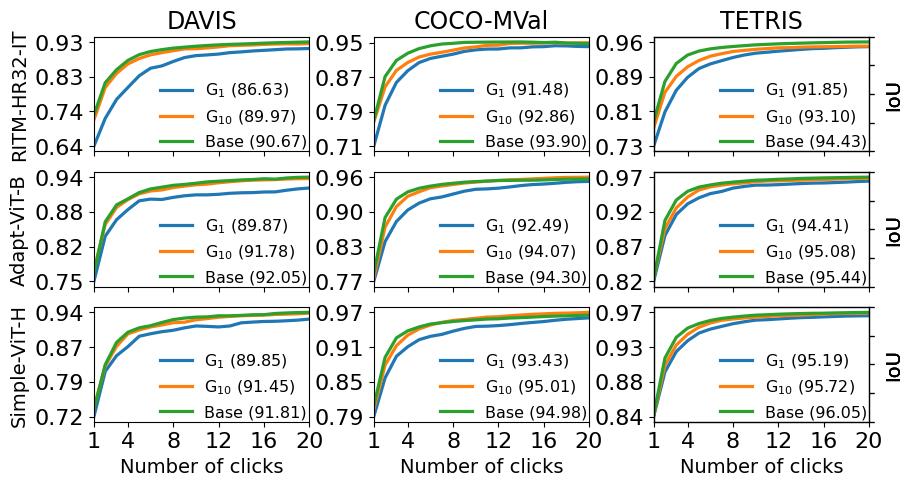

In [17]:
sns.set_palette("tab10")

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.18)

figure_name_mapping = {
 'coco_lvis_h32_itermask': 'RITM-HR32-IT',
 'adaptiveclick_base448_cocolvis': 'Adapt-ViT-B',
 'cocolvis_vit_huge': 'Simple-ViT-H'
}

for row, model_name in enumerate(['coco_lvis_h32_itermask', 
                                  'adaptiveclick_base448_cocolvis', 
                                  'cocolvis_vit_huge']):

    for idxx, dataset in enumerate(['DAVIS', 'COCO', 'TETRIS']):

        idx = row * 3 + idxx

        for suffix in ['Trajectory_BOUNDS_0.000_0.100_IOU',
                       'Trajectory_BOUNDS_0.900_1.000_IOU', 
                       'Base_IOU']:
            
            old = copy.deepcopy(figure_name_mapping[model_name])
        
            if 'DAVIS' in dataset:
                list(axes.flat)[idx].set_ylabel(old, fontsize=14)
            
            if '0.000_0.100' in suffix:
                lab = 'G$_{1}$'
            if '0.900_1.000' in suffix:
                lab = 'G$_{10}$'  
            if 'Base' in suffix:
                lab = 'Base'

            label = lab + ' (' + "{:.2f}".format(100 * (np.trapz(inverse_index[dataset][model_name][suffix].mean(axis=0)) / 19.)) + ")"

            sns.lineplot(x=list(range(1, 21)),
                         y = inverse_index[dataset][model_name][suffix].mean(axis=0), 
                         label=label, ax=list(axes.flat)[idx], linewidth = 2.3)

            name = dataset if 'TETRIS' not in dataset else "TETRIS"
            name = name if 'COCO' not in dataset else "COCO-MVal"

            if 'coco_lvis_h32_itermask' in model_name:
                list(axes.flat)[idx].set_title(name, fontsize=17)

            if row != 2:
                list(axes.flat)[idx].set_xlabel(None)
                list(axes.flat)[idx].set_xticklabels([])

            list(axes.flat)[idx].set_xlim(1, 20)
            list(axes.flat)[idx].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            list(axes.flat)[idx].tick_params(labelsize=16)
            list(axes.flat)[idx].xaxis.set_ticks([1, 4, 8, 12, 16, 20])

            if '0.000_0.100' in suffix:
                mins = 999
                maxs = 0
                for suffix in ['Trajectory_BOUNDS_0.000_0.100_IOU',
                       'Trajectory_BOUNDS_0.900_1.000_IOU', 'Base_IOU']:
                    vals = inverse_index[dataset][model_name][suffix].mean(axis=0)
                    if maxs < vals[-1]:
                        maxs = vals[-1]
                    if mins > vals[0]:
                        mins = vals[0]

            list(axes.flat)[idx].set_yticks(np.linspace(mins, maxs, 4))

            if row == 2:
                list(axes.flat)[idx].set_xlabel('Number of clicks', fontsize=14)

            if 'TETRIS' in dataset:
                ax_right = list(axes.flat)[idx].twinx()
                ax_right.set_ylabel('IoU', fontsize=14, x=-0.5)
                ax_right.set_yticklabels([])

            list(axes.flat)[idx].legend(loc="lower right", fontsize=11.5, 
                                        framealpha=0.0, borderaxespad=-0.27)

### Plot average User-IoU, STD, NSR (Fig. 7)

In [18]:
plt.figure(figsize=(6, 4))

tmp_df = pd.DataFrame(columns=['Dataset', 'x', 'y', 'idx'])

for idxx, dataset in enumerate(['GrabCut', 'Berkeley', 'DAVIS', 'COCO', 'TETRIS'][::-1]):

    means = []
    stds = []
    
    for row, model_name in enumerate(map_names_to_print.keys()):
        subset = inverse_index[dataset][model_name]['User_IOU']

        local_means = []
        local_stds = []
        
        for idx, elem in enumerate(subset):
            local_means.append(elem.mean())
            local_stds.append(elem.std())

        means.append(local_means)
        stds.append(local_stds)
        
    means = np.array(means).transpose(1, 0)
    stds = np.array(stds).transpose(1, 0)

    pairs = []
    for idx in range(len(means)):
        pairs.append([means[idx].mean(), stds[idx].mean()])
        tmp_df = pd.concat([tmp_df, pd.DataFrame([{"Dataset": dataset, "x": means[idx].mean(), 
                                                   "y": stds[idx].mean(), 'idx': idx}])], 
                           ignore_index=True)

tmp_df['nsr'] = tmp_df['y'] / tmp_df['x']
tmp_df.groupby(by='Dataset').mean()['nsr']

Dataset
Berkeley    0.165050
COCO        0.203376
DAVIS       0.241468
GrabCut     0.164166
TETRIS      0.215148
Name: nsr, dtype: float64

<Figure size 600x400 with 0 Axes>

In [19]:
names_map = {}
for it in dict(tmp_df.groupby(by='Dataset').mean()['nsr']).items():
    names_map[it[0]] = '%.2f' % (100 * it[1])

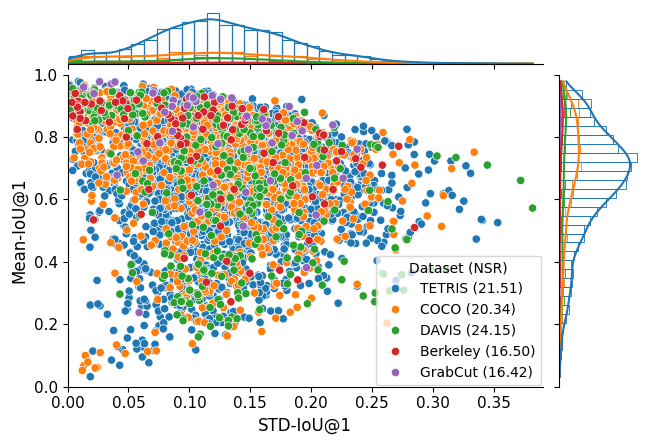

In [20]:
repl = {
    'GrabCut': "GrabCut (" + names_map['GrabCut'] + ")",
    'Berkeley': "Berkeley (" + names_map['Berkeley'] + ")",
    'DAVIS': "DAVIS (" + names_map['DAVIS'] + ")",
    'COCO': "COCO (" + names_map['COCO'] + ")",
    'TETRIS': "TETRIS (" + names_map['TETRIS'] + ")",
}

tmp_df['Dataset (NSR)'] = tmp_df['Dataset'].apply(lambda x: repl[x])
g = sns.JointGrid(data=tmp_df, x="y", y="x", hue="Dataset (NSR)", height=4.5)
g.fig.set_figwidth(7.0)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, fill=False, stat='density', kde=True, common_norm=True)
g.ax_marg_x.set_xlim(0, 0.39)
g.ax_marg_y.set_ylim(0, 1)
g.ax_joint.set_xlabel('STD-IoU@1', fontsize=12)
g.ax_joint.set_ylabel('Mean-IoU@1', fontsize=12)
g.ax_joint.tick_params(labelsize=11)
legend = g.ax_joint.legend(title="Dataset (NSR)", borderaxespad=0.1, 
                           fontsize=10, framealpha=0.75, frameon=True)
frame = legend.get_frame()
plt.savefig('MEAN_STD_DIST_NSR-new.pdf', bbox_inches='tight', pad_inches=0.00001)

### Plot Correlations (Supplementary, Fig. 14)

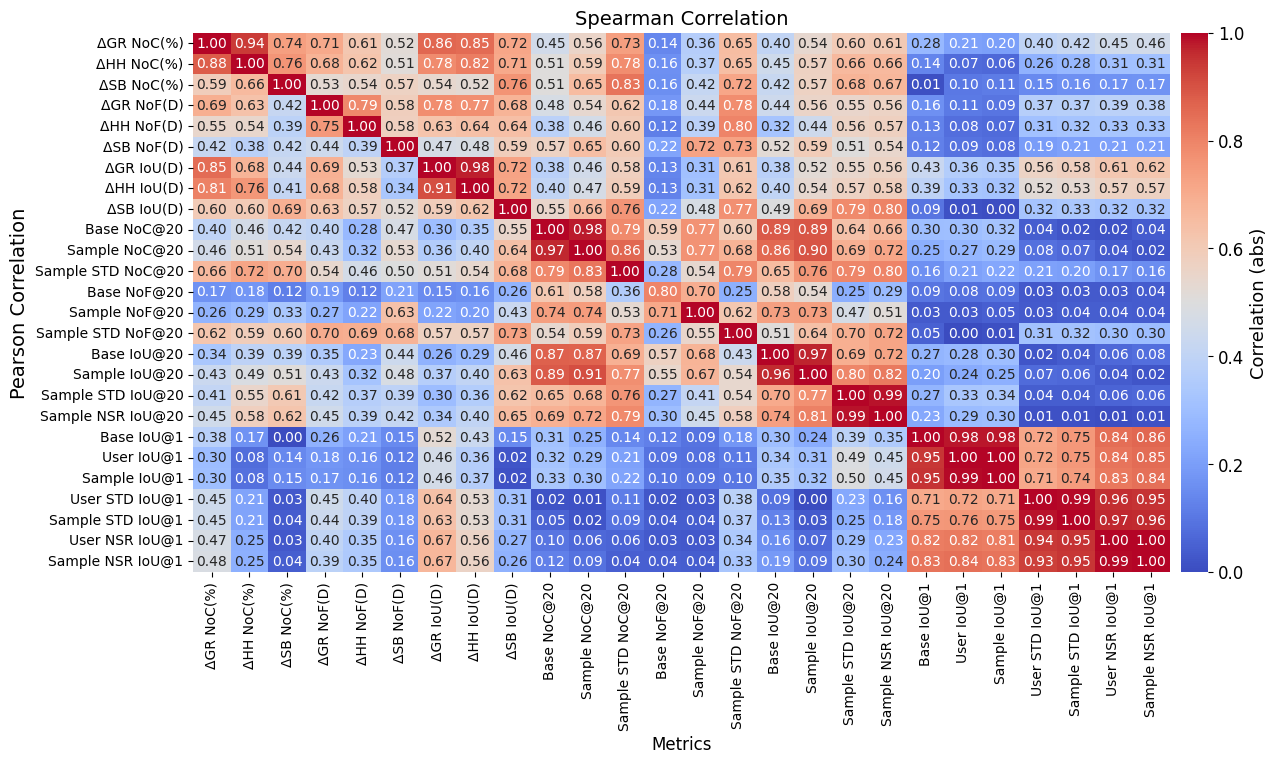

In [21]:
corrss_sp = df_metrics[cols_valid].corr(method='spearman')
corrss_sp.values[np.triu_indices_from(corrss_sp, 1)] = 0
corrss_pr = df_metrics[cols_valid].corr(method='pearson')
corrss_pr.values[np.tril_indices_from(corrss_pr, 0)] = 0
corrss = corrss_sp + corrss_pr

# Save csv for each dataset first, changing DS parameters
corrss.to_csv('corrs_' + DS + '.csv')

# Then run the following:
df_corr = pd.read_csv('corrs_GrabCut.csv', index_col=0).fillna(0)
for DS_name in ['Berkeley', 'DAVIS', 'COCO', 'TETRIS']:
    df_corr = df_corr + pd.read_csv('corrs_' + DS_name + '.csv', index_col=0)

plt.figure(figsize=(15, 7))
heatmap = sns.heatmap((df_corr.loc[cols_valid][cols_valid] / 5).abs(), annot=True, fmt='.2f', cmap="coolwarm",
             cbar_kws={"pad":0.01})
plt.gca().collections[0].set_clim(0,1)

# Adding the labels and title
plt.title('Spearman Correlation', fontsize=14)
plt.ylabel('Pearson Correlation', fontsize=14)
plt.xlabel('Metrics', fontsize=12)

# Modifying the color bar label font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Correlation (abs)', fontsize=13)